## Result Analysis
Let's first load and plot the training loss

The loss does seem to fall substantially from ~2.25 to ~0.18, most of this progress is within the first 1000 training epochs, again this is not unexpected

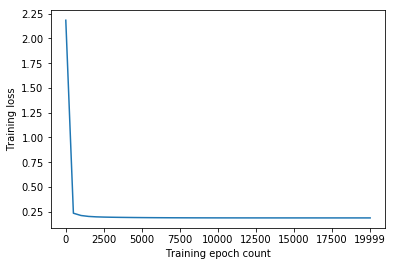

In [19]:
import numpy as np
from os.path import expanduser
import matplotlib.pyplot as plt
# enable in-line plotting in notebook
%matplotlib inline

homeDir = expanduser('~') 
lossFilepath = '{}/Data/morsum/training.csv'.format(homeDir)
trainingLossEntries = np.loadtxt(lossFilepath, delimiter=',')
epochs = trainingLossEntries[:,0].astype(int)
losses = trainingLossEntries[:,1]
del trainingLossEntries # delete original data to save memory

# to avoid use of the pyplot package I initially just printed the loss value over time
plt.plot(losses)
plt.ylabel('Training loss')
plt.xlabel('Training epoch count')
xTickIndices = np.arange(9)*5
plt.xticks(xTickIndices, epochs[xTickIndices])
plt.show()

In [ ]:
outputFilepath = '{}/Data/morsum/output.csv'.format(homeDir)
output = np.loadtxt(outputFilepath, delimiter=',')
targets = output[:,0]
predictions = output[:,1]
del output # delete original data to save memory

Load target and predicted prices